In [173]:
import os
import csv
import configparser
import json

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.ticker import FixedLocator, FuncFormatter, StrMethodFormatter
from scipy.stats import linregress
import networkx as nx

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['text.usetex'] = True

#cluster endpoints in base delta-nd 


In [174]:
# f = "FudanSELab-TrainTicket_v0.2.0_8cpu_PPTAM_29-03-2025"
# f = "FudanSELab-TrainTicket_v0.2.0_10cpu_PPTAM_02-06-2025"
# f = "FudanSELab-TrainTicket_v0.2.0_12cpu_PPTAM_01-06-2025"
# f = "FudanSELab-TrainTicket_v0.2.0_16cpu_PPTAM_23-05-2025"

# f = "CUHK-SE-Group-TrainTicket_8cpu_PPTAM_31-03-2025"
f = "CUHK-SE-Group-TrainTicket_10cpu_PPTAM_14-06-2025"
# f = "CUHK-SE-Group-TrainTicket_12cpu_PPTAM_15-06-2025"


prefix = f"./executed/2025-ICPE/{f}/executed"
prefix_for_plots = f

experiment_folders = sorted([name for name in os.listdir(prefix) if os.path.isdir(os.path.join(prefix, name))])

load_values = {}  

for folder in experiment_folders:
    config_path = os.path.join(prefix, folder, "configuration.ini")

    config = configparser.ConfigParser()
    config.read(config_path)
    load_value = config['CONFIGURATION']['LOAD']
    load_values[folder] = load_value

display(load_values)

{'202506140008-tt-test1': '1',
 '202506140028-tt-test2': '2',
 '202506140048-tt-test3': '4',
 '202506140108-tt-test4': '6',
 '202506140128-tt-test5': '8',
 '202506140148-tt-test6': '10',
 '202506140208-tt-test7': '15',
 '202506140228-tt-test8': '20',
 '202506140248-tt-test9': '25',
 '202506140308-tt-test10': '30'}

In [175]:
endpoints = set()

for folder in experiment_folders:
    csv_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(csv_path):
        print(f"Warning: {csv_path} does not exist, skipping.")
        continue

    with open(csv_path, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            name = row['Name']
            if name != "Aggregated" and name != "":
                endpoints.add(name)

endpoints = sorted(endpoints)

print("\nUnique API endpoints found:")
for name in endpoints:
    print(f"- {name}")


Unique API endpoints found:
- /api/v1/adminuserservice/users
- /api/v1/assuranceservice/assurances/types
- /api/v1/contactservice/contacts
- /api/v1/contactservice/contacts/account/user
- /api/v1/executeservice/execute/collected/order
- /api/v1/executeservice/execute/execute/order
- /api/v1/foodservice/foods/departure/shanghai/suzhou/D1345
- /api/v1/inside_pay_service/inside_payment
- /api/v1/orderservice/order/refresh
- /api/v1/preserveservice/preserve
- /api/v1/travelservice/trips/left
- /api/v1/users/login
- /index.html


In [176]:
endpoint_requirements = {}

for endpoint in endpoints:
    found = False
    for folder in experiment_folders:
        csv_path = os.path.join(prefix, folder, "result_stats.csv")
        
        if not os.path.exists(csv_path):
            continue

        with open(csv_path, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['Name'] == endpoint:
                    avg_response = float(row['Average Response Time'])
                    percentile_75 = float(row['75%'])
                    percentile_25 = float(row['25%'])

                    # Approximate standard deviation from IQR
                    iqr = percentile_75 - percentile_25
                    stddev = iqr / 1.35

                    # Calculate requirement
                    requirement = avg_response + 3 * stddev

                    endpoint_requirements[endpoint] = {
                        'Average Response Time': avg_response,
                        'Standard deviation': stddev,
                        'Requirement': requirement
                    }

                    found = True
                    break  # Found it, no need to search more
        if found:
            break

df = pd.DataFrame.from_dict(endpoint_requirements, orient='index')
df = df.reset_index().rename(columns={'index': 'Endpoint'})
df = df[['Endpoint', 'Average Response Time', 'Standard deviation', 'Requirement']]
df = df.round({
    'Average Response Time': 2,
    'Standard deviation': 2,
    'Requirement': 2
})

# Add line number starting from 1
df.insert(0, 'No.', range(1, len(df) + 1))

print("\nCalculated Requirements:")
display(df)


Calculated Requirements:


,No.,Endpoint,Average Response Time,Standard deviation,Requirement
0,1,/api/v1/adminuserservice/users,154.81,0.00,154.81
1,2,/api/v1/assuranceservice/assurances/types,13.00,1.48,17.44
2,3,/api/v1/contactservice/contacts,28.43,0.00,28.43
3,4,/api/v1/contactservice/contacts/account/user,16.23,1.48,20.68
4,5,/api/v1/executeservice/execute/collected/order,27.57,2.96,36.46
5,6,/api/v1/executeservice/execute/execute/order,26.95,2.96,35.84
6,7,/api/v1/foodservice/foods/departure/shanghai/s...,60.64,6.67,80.64
7,8,/api/v1/inside_pay_service/inside_payment,60.43,6.67,80.43
8,9,/api/v1/orderservice/order/refresh,17.68,3.70,28.79
9,10,/api/v1/preserveservice/preserve,309.48,14.81,353.92


{'/api/v1/adminuserservice/users': 1.1830334663791828,
 '/api/v1/assuranceservice/assurances/types': 0.6844030061230383,
 '/api/v1/contactservice/contacts': 1.0144451198292062,
 '/api/v1/contactservice/contacts/account/user': 0.6772979469659248,
 '/api/v1/executeservice/execute/collected/order': 1.324551763696126,
 '/api/v1/executeservice/execute/execute/order': 1.3893365001277933,
 '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345': 0.5842324746684046,
 '/api/v1/inside_pay_service/inside_payment': 1.3086837618189386,
 '/api/v1/orderservice/order/refresh': 1.3697419023703472,
 '/api/v1/preserveservice/preserve': 1.750343859049577,
 '/api/v1/travelservice/trips/left': 1.034127171829573,
 '/api/v1/users/login': 0.8379592743706898,
 '/index.html': 0.8088364814686175}

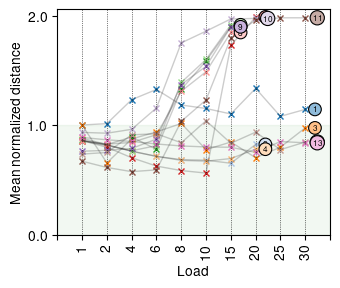

In [177]:
requirements = [endpoint_requirements[ep]['Requirement'] for ep in endpoints]

fig_width = 3.5
fig_height = 3
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

mark_coords = {}

cmap = colormaps.get_cmap('tab20') # or 'tab10', 'Set3', etc.
endpoint_colors = {ep: cmap(i) for i, ep in enumerate(endpoints)}

def brighten_color(color, factor=0.5):
    r, g, b, a = color
    r = r + (1.0 - r) * factor
    g = g + (1.0 - g) * factor
    b = b + (1.0 - b) * factor
    return (r, g, b, 1.0)  # Force alpha = 1

endpoint_background_colors = {ep: brighten_color(color) for ep, color in endpoint_colors.items()}

for experiment_number, folder in enumerate(experiment_folders, start=1):
    file_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(file_path):
        continue

    data = pd.read_csv(file_path, delimiter=",", decimal=".")
    
    for i, endpoint in enumerate(endpoints):
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            mean = float(row['Average Response Time'])
            ndist = (2 * mean) / (mean + requirements[i])

            # ax.plot(experiment_number, ndist, marker='x', markersize=4, color="steelblue")
            ax.plot(experiment_number, ndist, marker='x', markersize=4, color=endpoint_colors[endpoint], alpha=1)

            if endpoint not in mark_coords:
                mark_coords[endpoint] = []
            mark_coords[endpoint].append((experiment_number, ndist))

last_ndist_values1 = {endpoint: points[-1][1] for endpoint, points in mark_coords.items()}

target_load = "8"
target_folder = next(folder for folder, load in load_values.items() if load == target_load)
experiment_number = experiment_folders.index(target_folder) + 1  # +1 since enumerate starts at 1
last_ndist_values = {
    endpoint: ndist
    for endpoint, points in mark_coords.items()
    for exp_num, ndist in points
    if exp_num == experiment_number
}
display(last_ndist_values)

ax.set_title("")
ax.set_xlabel('Load')
ax.set_ylabel('Mean normalized distance')
ax.set_yscale("linear") #linear, log, symlog, logit
ax.set_ylim(0, None)
ax.set_xlim(0, len(experiment_folders) + 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))

def my_formatter(x, pos):
    x = int(x)
    if x < 1 or x > len(experiment_folders):
        return ""
    folder = experiment_folders[x-1]

    load = load_values[folder]
    return load

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

# Draw lines between points for each endpoint
for index, (endpoint, points) in enumerate(mark_coords.items()):
    points = sorted(points)
    x_vals, y_vals = zip(*points)
    ax.plot(x_vals, y_vals, color='black', alpha=0.2, linewidth=1)

    # Add index as the label near the last point
    last_x, last_y = points[-1]

    ax.text(last_x + 0.3, last_y, str(index + 1), fontsize=6, verticalalignment='center', bbox=dict(boxstyle="circle", fc=endpoint_background_colors[endpoint], ec="black", lw=0.8))

x_values = np.array(ax.get_xlim())
y_value = 1
ax.fill_between(x_values, y_value, color='green', alpha=0.05)

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-nd.pdf")
plt.show()


In [178]:
endpoint_slopes = {}

for endpoint in endpoints:
    loads = []
    max_response_times = []
    
    for folder in experiment_folders:
        file_path = os.path.join(prefix, folder, "result_stats.csv")
        
        if not os.path.exists(file_path):
            continue

        data = pd.read_csv(file_path, delimiter=",", decimal=".")
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            max_response_time = float(row['Max Response Time'])
            load = int(load_values[folder])

            loads.append(load)
            max_response_times.append(max_response_time)

    if len(loads) >= 2:
        slope, intercept, r_value, p_value, std_err = linregress(loads, max_response_times)
        endpoint_slopes[endpoint] = float(slope)
    else:
        endpoint_slopes[endpoint] = None  # not enough data to fit

slope_data = []
for endpoint, slope in endpoint_slopes.items():
    if slope is not None:
        slope_data.append({"Endpoint": endpoint, "Slope": f"{slope:.2f}"})
    else:
        slope_data.append({"Endpoint": endpoint, "Slope": "Not enough data"})

slope_df = pd.DataFrame(slope_data)
display(slope_df)


,Endpoint,Slope
0,/api/v1/adminuserservice/users,7.71
1,/api/v1/assuranceservice/assurances/types,-0.72
2,/api/v1/contactservice/contacts,1.27
3,/api/v1/contactservice/contacts/account/user,-2.69
4,/api/v1/executeservice/execute/collected/order,1032.99
5,/api/v1/executeservice/execute/execute/order,1257.28
6,/api/v1/foodservice/foods/departure/shanghai/s...,1843.73
7,/api/v1/inside_pay_service/inside_payment,1042.59
8,/api/v1/orderservice/order/refresh,10296.58
9,/api/v1/preserveservice/preserve,5591.60


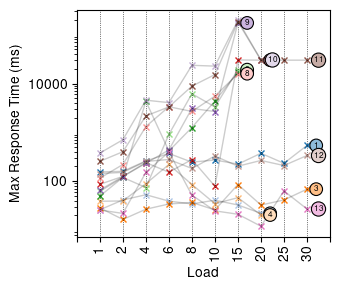

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

mark_coords = {}

for experiment_number, folder in enumerate(experiment_folders, start=1):
    file_path = os.path.join(prefix, folder, "result_stats.csv")
    
    if not os.path.exists(file_path):
        continue

    data = pd.read_csv(file_path, delimiter=",", decimal=".")

    for i, endpoint in enumerate(endpoints):
        endpoint_data = data[data['Name'] == endpoint]

        if endpoint_data.shape[0] == 1:
            row = endpoint_data.iloc[0]
            max_response_time = float(row['Max Response Time'])

            ax.plot(experiment_number, max_response_time, marker='x', markersize=4, color=endpoint_colors[endpoint], alpha=1)

            if endpoint not in mark_coords:
                mark_coords[endpoint] = []
            mark_coords[endpoint].append((experiment_number, max_response_time))

# Set axis properties
ax.set_title("")
ax.set_xlabel('Load')
ax.set_ylabel('Max Response Time (ms)')
ax.set_yscale("log")
# ax.set_ylim(0, None)
ax.set_xlim(0, len(experiment_folders) + 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))

def my_formatter(x, pos):
    x = int(x)
    if x < 1 or x > len(experiment_folders):
        return ""
    folder = experiment_folders[x-1]
    load = load_values[folder]
    return load

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.yaxis.set_major_locator(FixedLocator(ax.get_yticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)
ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

# Draw lines between points for each endpoint
for index, (endpoint, points) in enumerate(mark_coords.items()):
    points = sorted(points)
    x_vals, y_vals = zip(*points)
    
    # Plot connecting lines
    ax.plot(x_vals, y_vals, color='black', alpha=0.2, linewidth=1)

    # Add small index label near the last point
    last_x, last_y = x_vals[-1], y_vals[-1]

    ax.text(last_x + 0.3, last_y, str(index + 1), fontsize=6, verticalalignment='center', bbox=dict(boxstyle="circle", fc=endpoint_background_colors[endpoint], ec="black", lw=0.8))

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-max_response_times.pdf")
plt.show()


[{'endpoint': '/api/v1/adminuserservice/users', 'x_val': 1.1830334663791828}, {'endpoint': '/api/v1/assuranceservice/assurances/types', 'x_val': 0.6844030061230383}, {'endpoint': '/api/v1/contactservice/contacts', 'x_val': 1.0144451198292062}, {'endpoint': '/api/v1/contactservice/contacts/account/user', 'x_val': 0.6772979469659248}, {'endpoint': '/api/v1/executeservice/execute/collected/order', 'x_val': 1.324551763696126}, {'endpoint': '/api/v1/executeservice/execute/execute/order', 'x_val': 1.3893365001277933}, {'endpoint': '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345', 'x_val': 0.5842324746684046}, {'endpoint': '/api/v1/inside_pay_service/inside_payment', 'x_val': 1.3086837618189386}, {'endpoint': '/api/v1/orderservice/order/refresh', 'x_val': 1.3697419023703472}, {'endpoint': '/api/v1/preserveservice/preserve', 'x_val': 1.750343859049577}, {'endpoint': '/api/v1/travelservice/trips/left', 'x_val': 1.034127171829573}, {'endpoint': '/api/v1/users/login', 'x_val': 0.837959

['/api/v1/adminuserservice/users',
 '/api/v1/assuranceservice/assurances/types',
 '/api/v1/contactservice/contacts',
 '/api/v1/contactservice/contacts/account/user',
 '/api/v1/executeservice/execute/collected/order',
 '/api/v1/executeservice/execute/execute/order',
 '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345',
 '/api/v1/inside_pay_service/inside_payment',
 '/api/v1/orderservice/order/refresh',
 '/api/v1/preserveservice/preserve',
 '/api/v1/travelservice/trips/left',
 '/api/v1/users/login',
 '/index.html']

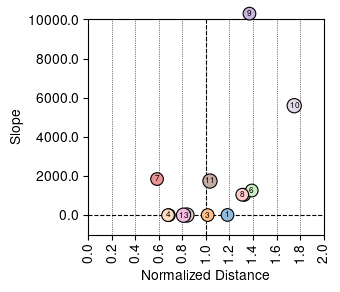

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
fig.tight_layout(pad=5.0)

endpoints = list(last_ndist_values.keys())
x_vals_with_endpoints = [{"endpoint": ep, "x_val": last_ndist_values[ep]} for ep in endpoints]
y_vals_with_endpoints = [{"endpoint": ep, "y_val": endpoint_slopes[ep]} for ep in endpoints]

print(x_vals_with_endpoints)
print(y_vals_with_endpoints)

endpoint_data = [
    {
        "endpoint": x["endpoint"],
        "x_val": x["x_val"],
        "y_val": y["y_val"]
    }
    for x, y in zip(x_vals_with_endpoints, y_vals_with_endpoints)
]

for idx, data in enumerate(endpoint_data, start=1):
    x = data["x_val"]
    y = data["y_val"]
    endpoint = data["endpoint"]

    ax.text(
        x, y, str(idx),
        fontsize=6, va='center', ha='center',
        bbox=dict(
            boxstyle="circle",
            fc=endpoint_background_colors[endpoint],
            ec="black", lw=0.8
        )
    )

display(endpoints)

ax.axvline(x=1, color='black', linestyle='--', linewidth=0.8)

ax.set_title("")
ax.set_xlabel('Normalized Distance')
ax.set_ylabel('Slope')

ax.set_yscale("linear")
ax.set_ylim(min(0, min(endpoint_slopes.values())), max(endpoint_slopes.values()))
ax.set_xlim(0, 2)
ax.set_ylim(-1000, 10000)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2))

def my_formatter(x, pos):
    return f"{x:.1f}"

ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
font = fm.FontProperties(family='Helvetica', size=10)
ax.set_xticklabels(ax.get_xticks(), fontproperties=font, rotation=90)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.01f}'))
ax.xaxis.set_major_formatter(FuncFormatter(my_formatter))

for xtick in ax.get_xticks():
    ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig(f"./{prefix_for_plots}-slope-vs-nd.pdf")
plt.show()


In [181]:
labels = []

data1_x=[{'endpoint': '/api/v1/adminuserservice/users', 'x_val': 0.13184168553181508}, {'endpoint': '/api/v1/assuranceservice/assurances/types', 'x_val': 0.45355809684036236}, {'endpoint': '/api/v1/contactservice/contacts', 'x_val': 0.3305732406504629}, {'endpoint': '/api/v1/contactservice/contacts/account/user', 'x_val': 0.5711762396794994}, {'endpoint': '/api/v1/executeservice/execute/collected/order', 'x_val': 0.9022213768149097}, {'endpoint': '/api/v1/executeservice/execute/execute/order', 'x_val': 0.8452698855541124}, {'endpoint': '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345', 'x_val': 0.4989014709242054}, {'endpoint': '/api/v1/inside_pay_service/inside_payment', 'x_val': 0.9867949950830003}, {'endpoint': '/api/v1/orderservice/order/refresh', 'x_val': 1.0531515883350044}, {'endpoint': '/api/v1/preserveservice/preserve', 'x_val': 1.4486731066458354}, {'endpoint': '/api/v1/travelservice/trips/left', 'x_val': 1.16476881141892}, {'endpoint': '/api/v1/users/login', 'x_val': 0.7409154021568274}, {'endpoint': '/index.html', 'x_val': 0.8180711608491257}]
data1_y=[{'endpoint': '/api/v1/adminuserservice/users', 'y_val': -25.540471303300645}, {'endpoint': '/api/v1/assuranceservice/assurances/types', 'y_val': -26.85666419250924}, {'endpoint': '/api/v1/contactservice/contacts', 'y_val': 0.2438084455027273}, {'endpoint': '/api/v1/contactservice/contacts/account/user', 'y_val': -1.0243829672005775}, {'endpoint': '/api/v1/executeservice/execute/collected/order', 'y_val': 873.7158106907189}, {'endpoint': '/api/v1/executeservice/execute/execute/order', 'y_val': 690.9727670366518}, {'endpoint': '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345', 'y_val': 1330.310102973114}, {'endpoint': '/api/v1/inside_pay_service/inside_payment', 'y_val': 973.5152331021543}, {'endpoint': '/api/v1/orderservice/order/refresh', 'y_val': 894.2589268274164}, {'endpoint': '/api/v1/preserveservice/preserve', 'y_val': 6962.942457512017}, {'endpoint': '/api/v1/travelservice/trips/left', 'y_val': 2591.290447248521}, {'endpoint': '/api/v1/users/login', 'y_val': 11.877789320760005}, {'endpoint': '/index.html', 'y_val': -2.819913139794552}]
data2_x=[{'endpoint': '/api/v1/adminuserservice/users', 'x_val': 1.1830334663791828}, {'endpoint': '/api/v1/assuranceservice/assurances/types', 'x_val': 0.6844030061230383}, {'endpoint': '/api/v1/contactservice/contacts', 'x_val': 1.0144451198292062}, {'endpoint': '/api/v1/contactservice/contacts/account/user', 'x_val': 0.6772979469659248}, {'endpoint': '/api/v1/executeservice/execute/collected/order', 'x_val': 1.324551763696126}, {'endpoint': '/api/v1/executeservice/execute/execute/order', 'x_val': 1.3893365001277933}, {'endpoint': '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345', 'x_val': 0.5842324746684046}, {'endpoint': '/api/v1/inside_pay_service/inside_payment', 'x_val': 1.3086837618189386}, {'endpoint': '/api/v1/orderservice/order/refresh', 'x_val': 1.3697419023703472}, {'endpoint': '/api/v1/preserveservice/preserve', 'x_val': 1.750343859049577}, {'endpoint': '/api/v1/travelservice/trips/left', 'x_val': 1.034127171829573}, {'endpoint': '/api/v1/users/login', 'x_val': 0.8379592743706898}, {'endpoint': '/index.html', 'x_val': 0.8088364814686175}]
data2_y=[{'endpoint': '/api/v1/adminuserservice/users', 'y_val': 7.714521117062313}, {'endpoint': '/api/v1/assuranceservice/assurances/types', 'y_val': -0.720250284744065}, {'endpoint': '/api/v1/contactservice/contacts', 'y_val': 1.2730225110018853}, {'endpoint': '/api/v1/contactservice/contacts/account/user', 'y_val': -2.6935130882093907}, {'endpoint': '/api/v1/executeservice/execute/collected/order', 'y_val': 1032.9928288683404}, {'endpoint': '/api/v1/executeservice/execute/execute/order', 'y_val': 1257.2791671387806}, {'endpoint': '/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345', 'y_val': 1843.7348313059713}, {'endpoint': '/api/v1/inside_pay_service/inside_payment', 'y_val': 1042.5945891832994}, {'endpoint': '/api/v1/orderservice/order/refresh', 'y_val': 10296.577410644222}, {'endpoint': '/api/v1/preserveservice/preserve', 'y_val': 5591.603737390116}, {'endpoint': '/api/v1/travelservice/trips/left', 'y_val': 1741.151759356549}, {'endpoint': '/api/v1/users/login', 'y_val': 3.4028915952316443}, {'endpoint': '/index.html', 'y_val': -3.267625195307688}]

labels = ["8 CPUs", "10 CPUs"]
prefix_for_plots = "CUHK-SE-TrainTicket"

def build_lookup(series):
    return {entry["endpoint"]: entry.get("x_val", entry.get("y_val")) for entry in series}

x1_lookup = build_lookup(data1_x)
y1_lookup = build_lookup(data1_y)
x2_lookup = build_lookup(data2_x)
y2_lookup = build_lookup(data2_y)
all_xvals = [[x1_lookup[ep], x2_lookup[ep]] for ep in endpoints if ep in x1_lookup and ep in x2_lookup]
all_yvals = [[y1_lookup[ep], y2_lookup[ep]] for ep in endpoints if ep in y1_lookup and ep in y2_lookup]
all_endpoint_names = [ep for ep in endpoints if ep in x1_lookup and ep in x2_lookup and ep in y1_lookup and ep in y2_lookup]
filtered_rows = [
    row for ep in all_endpoint_names
    for i, row in slope_df.iterrows()
    if row[0] == ep
]

slope_df = pd.DataFrame(filtered_rows).reset_index(drop=True)

/var/folders/yp/kzy8znfn1sl81jqfjm9wgrrm0000gn/T/ipykernel_36234/1009545194.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] == ep


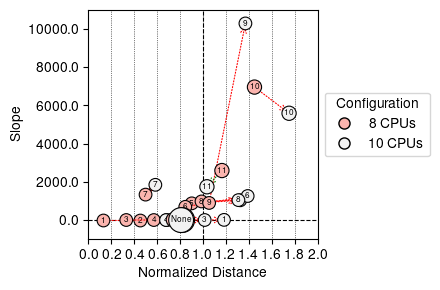

,Index,Endpoint,Direction,Slope Δ,NDist Δ
0,11.0,/api/v1/travelservice/trips/left,↑,-850.138688,-0.130642
1,NaN,/index.html,↑,-0.447712,-0.009235
2,7.0,/api/v1/foodservice/foods/departure/shanghai/s...,↓,513.424728,0.085331
3,12.0,/api/v1/users/login,↓,-8.474898,0.097044
4,4.0,/api/v1/contactservice/contacts/account/user,↓,-1.669130,0.106122
5,2.0,/api/v1/assuranceservice/assurances/types,↓,26.136414,0.230845
6,10.0,/api/v1/preserveservice/preserve,↓,-1371.338720,0.301671
7,9.0,/api/v1/orderservice/order/refresh,↓,9402.318484,0.316590
8,8.0,/api/v1/inside_pay_service/inside_payment,↓,69.079356,0.321889
9,5.0,/api/v1/executeservice/execute/collected/order,↓,159.277018,0.422330


This is pdfTeX, Version 3.141592653-2.6-1.40.27 (TeX Live 2025) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./CUHK-SE-TrainTicket-slope-vs-nd-0-2-table.tex
LaTeX2e <2024-11-01> patch level 2
L3 programming layer <2025-01-18>
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(/usr/local/texlive/2025/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2025/texmf-dist/tex/latex/booktabs/booktabs.sty)
(/usr/local/texlive/2025/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/local/texlive/2025/texmf-dist/tex/latex/graphics-def/pdftex.def)
(/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/mathcolor.ltx))
(/usr/local/texlive/2025/texmf-dist/tex/latex/colortbl/colortbl.sty
(/usr/local/texlive/2025/texmf-dist/tex/latex/tools/array.sty))
(/usr/local/texlive/2025/texmf-dist/tex/latex/graphics/dvipsna

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter, FuncFormatter, FixedLocator
import matplotlib.font_manager as fm
import numpy as np
from IPython.display import display, Latex

fig_width = 4.5
fig_height = 3

api_endpoints = {
    1: "/api/v1/adminuserservice/users",
    2: "/api/v1/assuranceservice/assurances/types",
    3: "/api/v1/contactservice/contacts",
    4: "/api/v1/contactservice/contacts/account/user",
    5: "/api/v1/executeservice/execute/collected/order",
    6: "/api/v1/executeservice/execute/execute/order",
    7: "/api/v1/foodservice/foods/departure/shanghai/suzhou/D1345",
    8: "/api/v1/inside_pay_service/inside_payment",
    9: "/api/v1/orderservice/order/refresh",
    10: "/api/v1/preserveservice/preserve",
    11: "/api/v1/travelservice/trips/left",
    12: "/api/v1/users/login",
    13: "/index.html"
}

def plot_slope_vs_nd(all_xvals, all_yvals, time_start=0, time_end=None, labels=None):
    if time_end is None:
        time_end = len(all_xvals[0])

    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
    fig.tight_layout(pad=5.0)

    num_endpoints = len(all_xvals)
    num_timepoints = time_end - time_start

    colors = plt.cm.Pastel1(np.linspace(0, 1, num_timepoints))

    for endpoint_index in range(num_endpoints):
        x_series = all_xvals[endpoint_index][time_start:time_end]
        y_series = all_yvals[endpoint_index][time_start:time_end]

        for i in range(num_timepoints - 1):
            arrow_color = 'green' if x_series[i + 1] < x_series[i] else 'red'
            ax.annotate(
                '',
                xy=(x_series[i + 1], y_series[i + 1]),
                xytext=(x_series[i], y_series[i]),
                arrowprops=dict(arrowstyle='->', linestyle=':', color=arrow_color, linewidth=0.8)
            )

        for time_index in range(num_timepoints):
            x = x_series[time_index]
            y = y_series[time_index]

            endpoint_string = all_endpoint_names[endpoint_index]
            api_index = next((i for i, v in api_endpoints.items() if v == endpoint_string), None)

            ax.text(
                x, y, str(api_index),
                fontsize=6, va='center', ha='center',
                bbox=dict(
                    boxstyle="circle",
                    fc=colors[time_index],
                    ec="black", lw=0.8
                )
            )
            # ax.plot(x, y, marker='o', markerfacecolor=colors[time_index], markeredgecolor='#444444', markersize=6)


    ax.axvline(x=1, color='black', linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

    ax.set_xlabel('Normalized Distance')
    ax.set_ylabel('Slope')
    ax.set_yscale("linear")
    ax.set_xlim(0, 2)
    ax.set_ylim(-1000, 11000)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.2))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.01f}'))

    for xtick in ax.get_xticks():
        ax.axvline(x=xtick, color='black', linestyle=':', linewidth=0.5)

    if labels:
        visible_labels = labels[time_start:time_end]
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=visible_labels[i],
                              markerfacecolor=colors[i], markeredgecolor='black', markersize=8)
                   for i in range(num_timepoints)]
        ax.legend(handles=handles, title="Configuration", loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
    })

    plt.tight_layout()
    plt.savefig(f"./{prefix_for_plots}-slope-vs-nd-{time_start}-{time_end}.pdf", bbox_inches='tight')
    plt.show()

def build_arrow_table_df(slope_df, all_xvals, all_yvals, time_start, time_end):
    rows = []
    for idx in range(len(all_xvals)):
        endpoint = slope_df.iloc[idx, 0]
        original_index = slope_df.index[idx]
        
        ndist_start = all_xvals[idx][time_start]
        ndist_end = all_xvals[idx][time_end - 1]
        slope_start = all_yvals[idx][time_start]
        slope_end = all_yvals[idx][time_end - 1]

        direction = '↑' if ndist_end < ndist_start else '↓'
        slope_diff = slope_end - slope_start
        ndist_diff = ndist_end - ndist_start

        endpoint_string = all_endpoint_names[original_index]
        api_index = next((i for i, v in api_endpoints.items() if v == endpoint_string), None)
        
        rows.append((api_index, endpoint, direction, slope_diff, ndist_diff))

    rows.sort(key=lambda x: x[4])
    df = pd.DataFrame(rows, columns=["Index", "Endpoint", "Direction", "Slope Δ", "NDist Δ"])
    return df

def latex_from_table_df(table):
    latex_lines = [
        r'\begin{tabular}{lcrr}',
        r'\toprule',
        r'Endpoint & Direction & Slope $\Delta$ & NDist $\Delta$ \\',
        r'\midrule'
    ]

    for _, row in table.iterrows():
        direction = r'\textcolor{red}{$\downarrow$}' if row['Direction'] == '↓' else r'\textcolor{mygreen}{$\uparrow$}'
        endpoint = str(row['Endpoint']).replace('_', r'\textunderscore{}')
        line = f'{endpoint} & {direction} & {row["Slope Δ"]:.2f} & {row["NDist Δ"]:.4f} \\\\'
        latex_lines.append(line)

    latex_lines.append(r'\bottomrule')
    latex_lines.append(r'\end{tabular}')
    return '\n'.join(latex_lines)


import subprocess
from pathlib import Path

def export_table_to_pdf(table, prefix_for_plots, time_start, time_end):
    tex_basename = f"{prefix_for_plots}-slope-vs-nd-{time_start}-{time_end}-table"
    tex_path = Path(f"./{tex_basename}.tex").resolve()

    tex_content = [
        r'\documentclass{article}',
        r'\usepackage{booktabs}',
        r'\usepackage[table,dvipsnames]{xcolor}',
        r'\usepackage{amsmath}',
        r'\usepackage{geometry}',
        r'\geometry{margin=1in}',
        r'\definecolor{mygreen}{rgb}{0,0.5,0}',
        r'\begin{document}',
        latex_from_table_df(table),
        r'\end{document}'
    ]

    with tex_path.open('w') as f:
        f.write('\n'.join(tex_content))

    subprocess.run(
        ['pdflatex', '-interaction=nonstopmode', tex_path.name],
        cwd=tex_path.parent
    )

    for ext in ['aux', 'log']:
        aux_file = tex_path.with_suffix(f'.{ext}')
        if aux_file.exists():
            aux_file.unlink()

    return tex_path.with_suffix('.pdf')

time_start = 0
time_end = 2
plot_slope_vs_nd(all_xvals, all_yvals, time_start=time_start, time_end=time_end, labels=labels)
table = build_arrow_table_df(slope_df, all_xvals, all_yvals, time_start=time_start, time_end=time_end)
display(table)
pdf_path = export_table_to_pdf(table, prefix_for_plots, time_start=time_start, time_end=time_end)